In [1]:
"""\
This script contains all the functions used to generate contact maps and plot genomic trakcs in the paper "Dynamics of microcompartment formation at the mitosis-to-G1 transition".

Contact maps are generated using cooltools: https://cooltools.readthedocs.io/en/latest/notebooks/viz.html
Genomic tracks are plotted using CoolBox: https://gangcaolab.github.io/CoolBox/quick_start_API.html

Maps and tracks can then be realigned to one another in Adobe Illustrator

Author: Viraat Goel
"""

# Plotting contact maps with cooltools

### Import core packages and define functions

In [2]:
%config InlineBackend.figure_format = 'svg'
import re
import json
import numpy as np
import pandas as pd
import cooler
import seaborn as sns
import os
import matplotlib.pyplot as plt
import chromosight.utils.detection as cud
import cooltools
import cooler
from mpl_toolkits.axes_grid import make_axes_locatable
from matplotlib.colors import LogNorm
import cooltools.lib.plotting

from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')

def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)
        
def avg(start, end):
    return (start + end) / 2

def avgInt(start, end):
    return (start + end) // 2

def subset_region(df, region):
    """
    Given a pattern dataframe and UCSC region string, retrieve only patterns in that region.
    """
    if(isMustache):
        df.rename(columns={'BIN1_CHR': 'chrom1', 'BIN1_START': 'start1', 'BIN1_END': 'end1', 'BIN2_CHROMOSOME': 'chrom2', 'BIN2_START': 'start2', 'BIN2_END': 'end2'}, inplace=True)
        
    if(isSIP):
        df.rename(columns={'chromosome1': 'chrom1', 'x1': 'start1', 'x2': 'end1', 'chromosome2': 'chrom2', 'y1': 'start2', 'y2': 'end2'}, inplace=True)

    # Split the region string at each occurence of - or : (yields 3 elements)
    chrom, start, end = re.split('[-:]', region)
    start, end = int(start), int(end)
    # Only keep patterns on the same chromosome as the region and
    # within the start-end interval
    subset = df.loc[
        (df.chrom1 == chrom) &
        (df.chrom2 == chrom) &
        (df.start1 >= start) &
        (df.start2 >= start) &
        (df.end1 < end) &
        (df.end2 < end), :
    ]
    return subset

def subset_region_manCalls(df, region):
    """
    Given a pattern dataframe and UCSC region string, retrieve only patterns in that region.
    """
    # Split the region string at each occurence of - or : (yields 3 elements)
    chrom, start, end = re.split('[-:]', region)
    start, end = int(start), int(end)
    # Only keep patterns on the same chromosome as the region and
    # within the start-end interval
    subset = df.loc[
        (df.chrom == chrom) &
        (df.start >= start) &
        (df.end < end), :
    ]
    return subset

In [6]:
# Jupyter Notebook formatting change to make it easier to visualize output results without having to scroll
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [7]:
# Choose your fighter; name region and Full vs. Zoom, connected via an underscore
view = 'Dag1_Full' # change this to whichever region / view you are interested in

if view == 'Klf1_Full':
    region = 'chr8:84846629-85856629'
    start, end = 84846629, 85856629
    extents = (start, end, end, start)
    norm_balanced_ROIs = LogNorm(vmax=0.025, vmin=0.000045)
    resy = 1600 # input the desired data resolution
    view_name = 'Klf1_Full_1600bp'
    
elif view == 'Klf1_Zoom':
    region = 'chr8:85270000-85850000'
    start, end = 85270000, 85850000
    extents = (start, end, end, start)
    norm_balanced_ROIs = LogNorm(vmax=0.02, vmin=0.00002)
    resy = 1000 # input the desired data resolution
    view_name = 'Klf1_Zoom_1000bp'

elif view == 'Dag1_Full':
    region = 'chr9:106675000-108600000'
    start, end = 106675000, 108600000
    extents = (start, end, end, start)
    norm_balanced_ROIs = LogNorm(vmax=0.050, vmin=0.000025)
    resy = 3200 # input the desired data resolution
    view_name = 'Dag1_Full_3200bp'

elif view == 'Dag1_Main':
    region = 'chr9:107100000-108600000'
    start, end = 107100000, 108600000
    extents = (start, end, end, start)
    norm_balanced_ROIs = LogNorm(vmax=0.050, vmin=0.000025)
    resy = 3200 # input the desired data resolution
    view_name = 'Dag1_Main_3200bp'

elif view == 'Dag1_Zoom':
    region = 'chr9:107800000-108565000'
    start, end = 107800000, 108565000
    extents = (start, end, end, start)
    norm_balanced_ROIs = LogNorm(vmax=0.032, vmin=0.000065)
    resy = 2000 # input the desired data resolution
    view_name = 'Dag1_Zoom_2000bp'

elif view == 'Id1_Full':
    region = 'chr2:151920000-153000000'
    start, end = 151920000, 153000000
    extents = (start, end, end, start)
    norm_balanced_ROIs = LogNorm(vmax=0.025, vmin=0.00005)
    resy = 2000 # input the desired data resolution
    view_name = 'Id1_Full_2000bp'

elif view == 'Id1_Zoom':
    region = 'chr2:152122000-152709500'
    start, end = 152122000, 152709500
    extents = (start, end, end, start)
    norm_balanced_ROIs = LogNorm(vmax=0.016, vmin=0.000027)
    resy = 1000 # input the desired data resolution
    view_name = 'Id1_Zoom_1000bp'

elif view == 'Cdt1_Full':
    region = 'chr8:122950000-124110000'
    start, end = 122950000, 124110000
    extents = (start, end, end, start)
    norm_balanced_ROIs = LogNorm(vmax=0.050, vmin=0.00020)
    resy = 3200 # input the desired data resolution
    view_name = 'Cdt1_Full_3200bp'

elif view == 'Cdt1_Zoom':
    region = 'chr8:122970000-123582500'
    start, end = 122970000, 123582500
    extents = (start, end, end, start)
    norm_balanced_ROIs = LogNorm(vmax=0.058, vmin=0.00024)
    resy = 2000 # input the desired data resolution
    view_name = 'Cdt1_Zoom_2000bp'

elif view == 'Myc_Full':
    region = 'chr15:61810000-63684000'
    start, end = 61810000, 63684000
    extents = (start, end, end, start)
    norm_balanced_ROIs = LogNorm(vmax=0.036, vmin=0.000024)
    resy = 5000 # input the desired data resolution
    view_name = 'Myc_Full_5000bp'

elif view == 'Myc_Zoom':
    region = 'chr15:61832000-62122000'
    start, end = 61832000, 62122000
    extents = (start, end, end, start)
    norm_balanced_ROIs = LogNorm(vmax=0.024, vmin=0.000020)
    resy = 800 # input the desired data resolution
    view_name = 'Myc_Zoom_800bp'

else: print("Invalid viewpoint requested; please provide a valid viewpoint name")

### RCMC or Hi-C Contact Maps Across M-to-G1

In [8]:
# Load in coolers for the RCMC or Hi-C datasets of interest
clr_RCMC_PM = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resy))
clr_RCMC_AT = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resy))
clr_RCMC_EG1 = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resy))
clr_RCMC_MG1 = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resy))
clr_RCMC_LG1 = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resy))
clr_RCMC_Asyn = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resy))

f, axs = plt.subplots(
    figsize=(10, 12),
    nrows=3,
    ncols=2,
    sharex=True,
    sharey=True
)

ax = axs[0,0]
ax.set_title('RCMC ProMeta')
im = ax.matshow(
    clr_RCMC_PM.matrix(balance=True).fetch(region),
    cmap='fall',
    norm = norm_balanced_ROIs,
    extent=extents
);
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04);

ax = axs[0,1]
ax.set_title('RCMC AnaTelo')
im = ax.matshow(
    clr_RCMC_AT.matrix(balance=True).fetch(region),
    cmap='fall',
    norm = norm_balanced_ROIs,
    extent=extents
);
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04);

ax = axs[1,0]
ax.set_title('RCMC Early G1')
im = ax.matshow(
    clr_RCMC_EG1.matrix(balance=True).fetch(region),
    cmap='fall',
    norm = norm_balanced_ROIs,
    extent=extents
);
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04);

ax = axs[1,1]
ax.set_title('RCMC Mid G1')
im = ax.matshow(
    clr_RCMC_MG1.matrix(balance=True).fetch(region),
    cmap='fall',
    norm = norm_balanced_ROIs,
    extent=extents
);
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04);

ax = axs[2,0]
ax.set_title('RCMC Late G1')
im = ax.matshow(
    clr_RCMC_LG1.matrix(balance=True).fetch(region),
    cmap='fall',
    norm = norm_balanced_ROIs,
    extent=extents
);
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04);

ax = axs[2,1]
ax.set_title('RCMC Async')
im = ax.matshow(
    clr_RCMC_Async.matrix(balance=True).fetch(region),
    cmap='fall',
    norm = norm_balanced_ROIs,
    extent=extents
);
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04);

for ax in axs.ravel():
    format_ticks(ax, rotate=False)
plt.tight_layout()

plt.savefig('SAVE_DIRECTORY/FILE_NAME.svg', dpi=1200) # swap out .svg for the desired output file format

### RCMC Contact Maps Across M-to-G1 with Loop Calls

In [10]:
colnames=['chrom', 'start', 'end']
loops = pd.read_csv('FILE_PATH_TO_LOOP_CALLS.bed', sep='\t', names=colnames, header=None)
loops = subset_region_manCalls(loops, region)

clr_RCMC_PM = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resy))
clr_RCMC_AT = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resy))
clr_RCMC_EG1 = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resy))
clr_RCMC_MG1 = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resy))
clr_RCMC_LG1 = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resy))
clr_RCMC_Asyn = cooler.Cooler('FILE_PATH_TO_MCOOL::resolutions/' + str(resy))

f, axs = plt.subplots(
    figsize=(10, 12),
    nrows=3,
    ncols=2,
    sharex=True,
    sharey=True
)
dotSize = 3

ax = axs[0,0]
ax.set_title('RCMC ProMeta')
im = ax.matshow(
    clr_RCMC_PM.matrix(balance=True).fetch(region),
    cmap='fall',
    norm = norm_balanced_ROIs,
    extent=extents
);
ax.scatter(loops.start, loops.end, edgecolors='b', s=dotSize, facecolors='none')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04);

ax = axs[0,1]
ax.set_title('RCMC AnaTelo')
im = ax.matshow(
    clr_RCMC_AT.matrix(balance=True).fetch(region),
    cmap='fall',
    norm = norm_balanced_ROIs,
    extent=extents
);
ax.scatter(loops.start, loops.end, edgecolors='b', s=dotSize, facecolors='none')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04);

ax = axs[1,0]
ax.set_title('RCMC Early G1')
im = ax.matshow(
    clr_RCMC_EG1.matrix(balance=True).fetch(region),
    cmap='fall',
    norm = norm_balanced_ROIs,
    extent=extents
);
ax.scatter(loops.start, loops.end, edgecolors='b', s=dotSize, facecolors='none')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04);

ax = axs[1,1]
ax.set_title('RCMC Mid G1')
im = ax.matshow(
    clr_RCMC_MG1.matrix(balance=True).fetch(region),
    cmap='fall',
    norm = norm_balanced_ROIs,
    extent=extents
);
ax.scatter(loops.start, loops.end, edgecolors='b', s=dotSize, facecolors='none')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04);

ax = axs[2,0]
ax.set_title('RCMC Late G1')
im = ax.matshow(
    clr_RCMC_LG1.matrix(balance=True).fetch(region),
    cmap='fall',
    norm = norm_balanced_ROIs,
    extent=extents
);
ax.scatter(loops.start, loops.end, edgecolors='b', s=dotSize, facecolors='none')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04);

ax = axs[2,1]
ax.set_title('RCMC Async')
im = ax.matshow(
    clr_RCMC_Async.matrix(balance=True).fetch(region),
    cmap='fall',
    norm = norm_balanced_ROIs,
    extent=extents
);
ax.scatter(loops.start, loops.end, edgecolors='b', s=dotSize, facecolors='none')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04);

for ax in axs.ravel():
    format_ticks(ax, rotate=False)
plt.tight_layout()

plt.savefig('SAVE_DIRECTORY/FILE_NAME.svg', dpi=1200) # swap out .svg for the desired output file format

# Plotting genomic tracks with CoolBox

### Import core packages and define functions

In [2]:
import pandas as pd
from scipy.sparse import coo_matrix
from coolbox.api import *
import coolbox
from coolbox.core.track.hicmat import Cool
from coolbox.utilities import GenomeRange, correspond_track
import bbi

import numpy as np # for manipulating arrays
import os # for making/deleting directories
import javabridge # for interfacing with java (required for bioformats)
import bioformats # for reading image series - CAN'T GET TO WORK
from tifffile import xml2dict # for parsing the metadata from bioformats
import pickle # for saving python objects and other data
from pathlib import Path
import bioframe
import cooler 
import h5py
import matplotlib
import matplotlib as mpl

# set plotting parameters & standard settings
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 6})

# for plotting images
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Rectangle
from matplotlib import animation
import pandas as pd

def gridspec_inches(
    wcols,
    hrows,
    wspace=0.75,
    hspace=0.5,
    fig_kwargs={}):

    fig = plt.figure()
    fig_height_inches = (
        sum(hrows)
        )

    fig_width_inches = (
        sum(wcols)
        )

    fig=plt.figure(
        figsize=(fig_width_inches,fig_height_inches),
        subplotpars=matplotlib.figure.SubplotParams(
        left=0,
        right=1,
        bottom=0,
        top=1,
        wspace =0,
        hspace = 0.0),
        **fig_kwargs)
    fig.set_size_inches(fig_width_inches,fig_height_inches,forward=True)

    gs = matplotlib.gridspec.GridSpec(
        len(hrows),
        len(wcols),
        left=0,
        right=1,
        top=1,
        bottom=0,
        wspace=wspace,
        hspace=hspace,
        width_ratios=wcols,
        height_ratios=hrows
        )
    return fig, gs

In [1]:
# Jupyter Notebook formatting change to make it easier to visualize output results without having to scroll
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Choose your fighter; name region and Full vs. Zoom, connected via an underscore
view = 'Dag1_Full' # change this to whichever region / view you are interested in

if view == 'Klf1_Full':
    region = 'chr8:84846629-85856629'
    start, end = 84846629, 85856629
    extents = (start, end, end, start)
    resy = 1600 # input the desired data resolution
    view_name = 'Klf1_Full_1600bp'
    
elif view == 'Klf1_Zoom':
    region = 'chr8:85270000-85850000'
    start, end = 85270000, 85850000
    extents = (start, end, end, start)
    resy = 1000 # input the desired data resolution
    view_name = 'Klf1_Zoom_1000bp'

elif view == 'Dag1_Full':
    region = 'chr9:106675000-108600000'
    start, end = 106675000, 108600000
    extents = (start, end, end, start)
    resy = 3200 # input the desired data resolution
    view_name = 'Dag1_Full_3200bp'

elif view == 'Dag1_Main':
    region = 'chr9:107100000-108600000'
    start, end = 107100000, 108600000
    extents = (start, end, end, start)
    resy = 3200 # input the desired data resolution
    view_name = 'Dag1_Main_3200bp'

elif view == 'Dag1_Zoom':
    region = 'chr9:107800000-108565000'
    start, end = 107800000, 108565000
    extents = (start, end, end, start)
    resy = 2000 # input the desired data resolution
    view_name = 'Dag1_Zoom_2000bp'

elif view == 'Id1_Full':
    region = 'chr2:151920000-153000000'
    start, end = 151920000, 153000000
    extents = (start, end, end, start)
    resy = 2000 # input the desired data resolution
    view_name = 'Id1_Full_2000bp'

elif view == 'Id1_Zoom':
    region = 'chr2:152122000-152709500'
    start, end = 152122000, 152709500
    extents = (start, end, end, start)
    resy = 1000 # input the desired data resolution
    view_name = 'Id1_Zoom_1000bp'

elif view == 'Cdt1_Full':
    region = 'chr8:122950000-124110000'
    start, end = 122950000, 124110000
    extents = (start, end, end, start)
    resy = 3200 # input the desired data resolution
    view_name = 'Cdt1_Full_3200bp'

elif view == 'Cdt1_Zoom':
    region = 'chr8:122970000-123582500'
    start, end = 122970000, 123582500
    extents = (start, end, end, start)
    resy = 2000 # input the desired data resolution
    view_name = 'Cdt1_Zoom_2000bp'

elif view == 'Myc_Full':
    region = 'chr15:61810000-63684000'
    start, end = 61810000, 63684000
    extents = (start, end, end, start)
    resy = 5000 # input the desired data resolution
    view_name = 'Myc_Full_5000bp'

elif view == 'Myc_Zoom':
    region = 'chr15:61832000-62122000'
    start, end = 61832000, 62122000
    extents = (start, end, end, start)
    resy = 800 # input the desired data resolution
    view_name = 'Myc_Zoom_800bp'

else: print("Invalid viewpoint requested; please provide a valid viewpoint name")

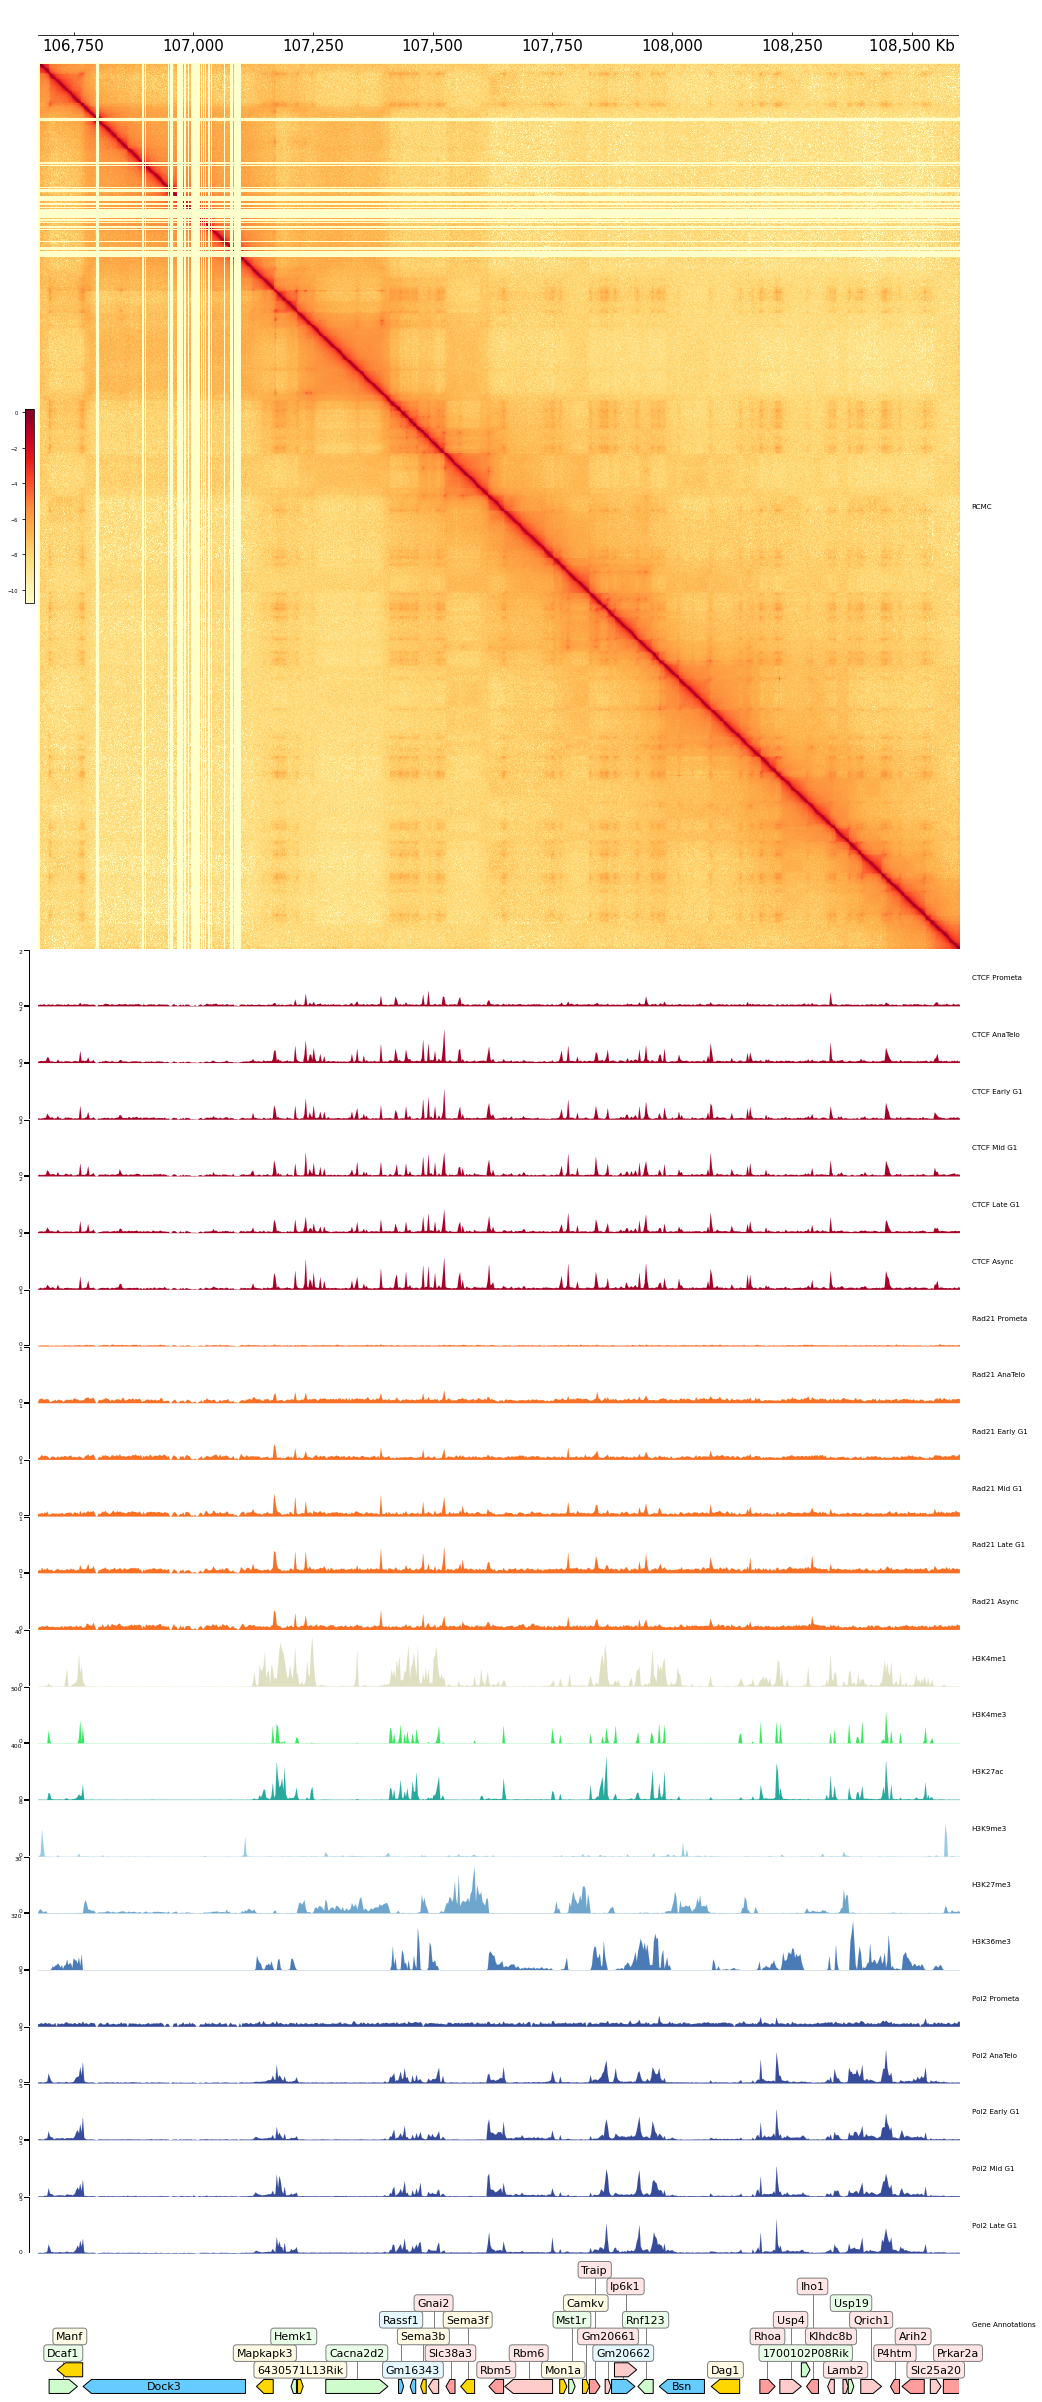

In [10]:
# Generate ChIP tracks for visualizations of loci with all possible genomic tracks

mcool = XAxis() + \
Cool(f"FILE_PATH_TO_MCOOL", resolution=resy, style="matrix", depth_ratio=0.85, balance=True, cmap="YlOrRd") + Title("RCMC")

ctcf_pm = BigWig(f"FILE_PATH_TO_BIGWIG") + Title("CTCF Prometa") + Color("#A50026") + MinValue(0) + MaxValue(2)

ctcf_at = BigWig(f"FILE_PATH_TO_BIGWIG") + Title("CTCF AnaTelo") + Color("#A50026") + MinValue(0) + MaxValue(2)

ctcf_eg = BigWig(f"FILE_PATH_TO_BIGWIG") + Title("CTCF Early G1") + Color("#A50026") + MinValue(0) + MaxValue(2)

ctcf_mg = BigWig(f"FILE_PATH_TO_BIGWIG") + Title("CTCF Mid G1") + Color("#A50026") + MinValue(0) + MaxValue(2)

ctcf_lg = BigWig(f"FILE_PATH_TO_BIGWIG") + Title("CTCF Late G1") + Color("#A50026") + MinValue(0) + MaxValue(2)

ctcf_async = BigWig(f"FILE_PATH_TO_BIGWIG") + Title("CTCF Async") + Color("#A50026") + MinValue(0) + MaxValue(2)

rad21_pm = BigWig(f"FILE_PATH_TO_BIGWIG") + Title("RAD21 Prometa") + Color("#F87024") + MinValue(0) + MaxValue(1)

rad21_at = BigWig(f"FILE_PATH_TO_BIGWIG") + Title("RAD21 AnaTelo") + Color("#F87024") + MinValue(0) + MaxValue(1)

rad21_eg = BigWig(f"FILE_PATH_TO_BIGWIG") + Title("RAD21 Early G1") + Color("#F87024") + MinValue(0) + MaxValue(1)

rad21_mg = BigWig(f"FILE_PATH_TO_BIGWIG") + Title("RAD21 Mid G1") + Color("#F87024") + MinValue(0) + MaxValue(1)

rad21_lg = BigWig(f"FILE_PATH_TO_BIGWIG") + Title("RAD21 Late G1") + Color("#F87024") + MinValue(0) + MaxValue(1)

rad21_async = BigWig(f"FILE_PATH_TO_BIGWIG") + Title("RAD21 Async") + Color("#F87024") + MinValue(0) + MaxValue(1)

pol2_pm = BigWig(f"FILE_PATH_TO_BIGWIG") + Title("POL2 Prometa") + Color("#364B9A") + MinValue(0) + MaxValue(5)

pol2_at = BigWig(f"FILE_PATH_TO_BIGWIG") + Title("POL2 AnaTelo") + Color("#364B9A") + MinValue(0) + MaxValue(5)

pol2_eg = BigWig(f"FILE_PATH_TO_BIGWIG") + Title("POL2 Early G1") + Color("#364B9A") + MinValue(0) + MaxValue(5)

pol2_mg = BigWig(f"FILE_PATH_TO_BIGWIG") + Title("POL2 Mid G1") + Color("#364B9A") + MinValue(0) + MaxValue(5)

pol2_lg = BigWig(f"FILE_PATH_TO_BIGWIG") + Title("POL2 Late G1") + Color("#364B9A") + MinValue(0) + MaxValue(5)

h3k4me1 = BigWig(f"FILE_PATH_TO_BIGWIG") + Title("H3K4me1") + Color("#DFDFC2") + MinValue(0) + MaxValue(40)

h3k4me3 = BigWig(f"FILE_PATH_TO_BIGWIG") + Title("H3K4me3") + Color("#39E75F") + MinValue(0) + MaxValue(500)

h3k27ac = BigWig(f"FILE_PATH_TO_BIGWIG") + Title("H3K27ac") + Color("#28A99E") + MinValue(0) + MaxValue(400)

h3k9me3 = BigWig(f"FILE_PATH_TO_BIGWIG") + Title("H3K9me3") + Color("#98CAE1") + MinValue(0) + MaxValue(8)

h3k27me3 = BigWig(f"FILE_PATH_TO_BIGWIG") + Title("H3K27me3") + Color("#6EA6CD") + MinValue(0) + MaxValue(30)

h3k36me3 = BigWig(f"FILE_PATH_TO_BIGWIG") + Title("H3K36me3") + Color("#4A7BB7") + MinValue(0) + MaxValue(320)

gata1 = BigWig(f"FILE_PATH_TO_BIGWIG") + Title("GATA1") + Color("#4A7BB7") + MinValue(0) + MaxValue(10)

genes = GTF('FILE_PATH_TO_GTF') + TrackHeight(5) + Title("Gene Annotations")

frame = mcool + ctcf_pm + ctcf_at + ctcf_eg + ctcf_mg + ctcf_lg + ctcf_async + rad21_pm + rad21_at + rad21_eg + rad21_mg + rad21_lg + rad21_async + h3k4me1 + h3k4me3 + h3k27ac + h3k9me3 + h3k27me3 + h3k36me3 + pol2_pm + pol2_at + pol2_eg + pol2_mg + pol2_lg + genes
fig = frame.plot(region)

fig.savefig('SAVE_DIRECTORY/FILE_NAME.svg', dpi=1200) # swap out .svg for the desired output file formatfig